In [ ]:
!pip install tensorflow

import os
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

In [ ]:
import os
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

# VGG16 모델 로드 및 특징 추출 부분만 사용
base_model = VGG16(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)

# 특징 추출 함수
def extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # VGG16 입력 크기 맞춤
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    features = model.predict(img)
    return features

# 각 프레임 이미지 파일에서 특징 추출 및 저장
def process_frames(frame_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for root, _, files in os.walk(frame_dir):
        for file in files:
            if file.endswith('.png'):
                frame_path = os.path.join(root, file)
                features = extract_features(frame_path)
                
                # 영상 별 하위 폴더 생성
                video_name = os.path.basename(root)
                video_output_dir = os.path.join(output_dir, video_name)
                if not os.path.exists(video_output_dir):
                    os.makedirs(video_output_dir)
                
                feature_file = os.path.join(video_output_dir, file.replace('.png', '.npy'))
                np.save(feature_file, features)

# 프레임 이미지 파일이 저장된 디렉터리
frame_dir = './open-eqa/data/frames/scannet-v0/'  # 각 영상의 프레임이 저장된 상위 폴더
output_dir = './feature_vector/'  # 특징 벡터 저장 디렉터리

# 프레임 처리 시작
process_frames(frame_dir, output_dir)


           0         1          2         3     4     5         6     \
0      0.000000  0.000000   0.000000  0.000000   0.0   0.0  0.000000   
1      0.000000  0.000000   0.000000  6.854768   0.0   0.0  0.000000   
2      0.000000  0.000000   7.443471  0.000000   0.0   0.0  0.000000   
3      9.024185  0.000000   0.000000  0.000000   0.0   0.0  0.000000   
4      0.000000  0.000000   0.000000  0.000000   0.0   0.0  0.000000   
...         ...       ...        ...       ...   ...   ...       ...   
53188  0.000000  5.608954   0.000000  0.000000   0.0   0.0  6.087229   
53189  0.000000  0.000000   0.000000  0.000000   0.0   0.0  0.000000   
53190  0.000000  0.000000   5.111444  0.000000   0.0   0.0  4.322211   
53191  0.000000  3.360897   0.000000  0.000000   0.0   0.0  0.000000   
53192  0.000000  8.106494  11.504610  0.000000   0.0   0.0  0.000000   

            7         8          9     ...      4086      4087      4088  \
0       8.850692  0.000000   7.185484  ...  5.105660  3.012

/home/jin/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


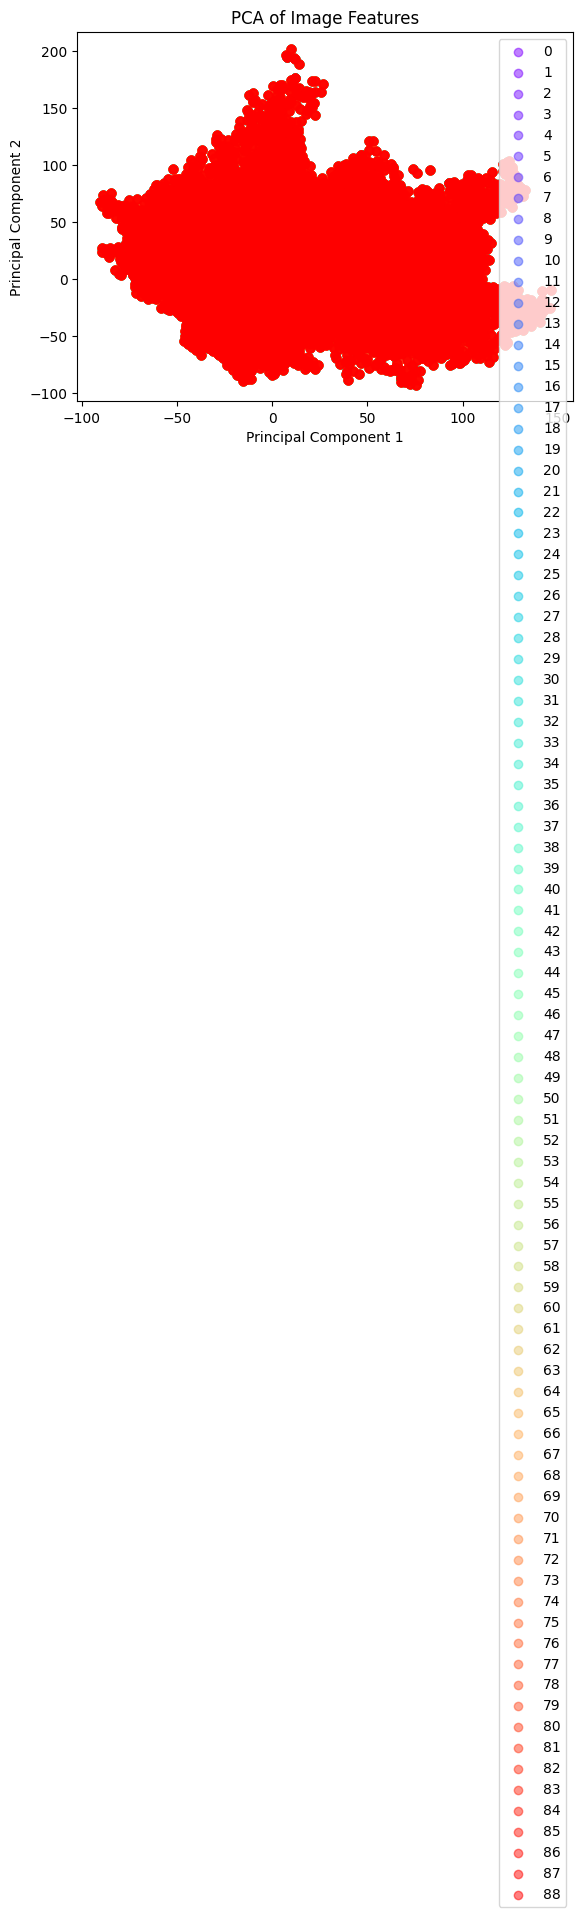

In [11]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

frame_dir = './open-eqa/data/frames/scannet-v0/'  # 각 영상의 프레임이 저장된 상위 폴더
output_dir = './feature_vector/'  # 특징 벡터 저장 디렉터리
def load_features(feature_dir):
    features = []
    for root, dirs, files in os.walk(feature_dir):
        for file in files:
            if file.endswith('.npy'):
                feature_path = os.path.join(root, file)
                feature = np.load(feature_path)
                features.append(feature.flatten())
    return np.array(features)

# 모든 특징 벡터 로드
features = load_features(output_dir)
df = pd.DataFrame(features)
print(df)


# PCA를 사용하여 특징 벡터의 차원을 줄임
def apply_pca(features, n_components=3):
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(features)
    return pca_result

# 시각화
def plot_pca(pca_result):
    colors = plt.cm.rainbow(np.linspace(0, 1, 89))

    for i in range(0,89):
        plt.scatter(pca_result[:, 0], pca_result[:, 1], color=colors[i], label=i, alpha=0.5)

    plt.title('PCA of Image Features')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

# PCA 적용
pca_result = apply_pca(features)

# 시각화
plot_pca(pca_result)

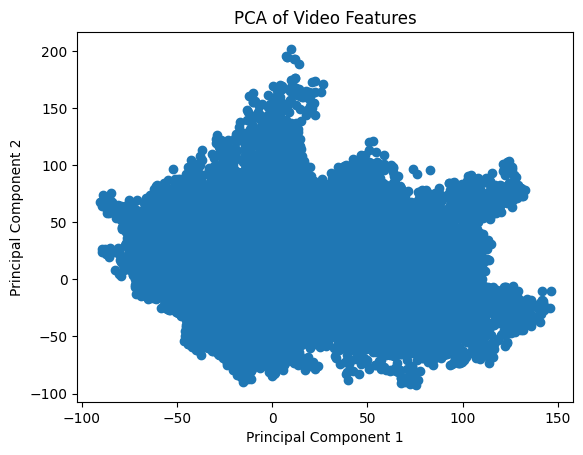

In [10]:

# PCA를 사용한 차원 축소
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)

# 시각화
plt.scatter(pca_result[:, 0], pca_result[:, 1])
plt.title('PCA of Video Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


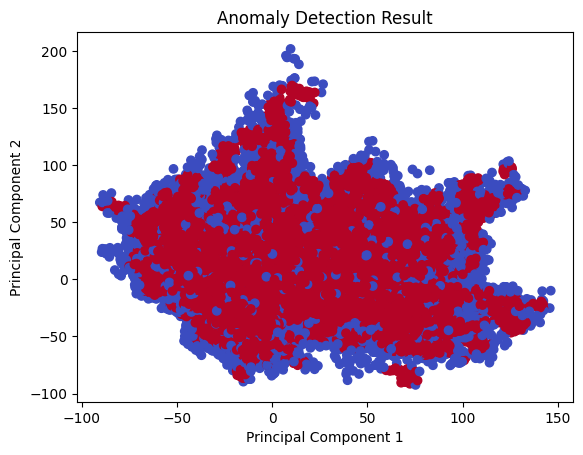

In [14]:
from sklearn.neighbors import LocalOutlierFactor

# 이상치 탐지
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
outliers = clf.fit_predict(pca_result)

# 이상치 시각화
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=outliers, cmap='coolwarm')
plt.title('Anomaly Detection Result')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


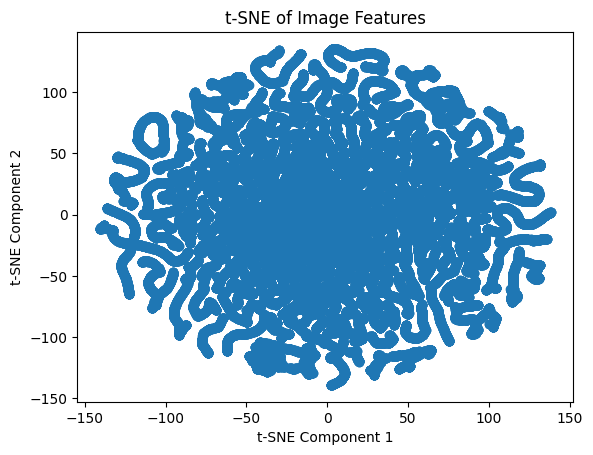

In [11]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# t-SNE를 사용하여 특징 벡터의 차원을 줄임
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(features)

# 시각화
plt.scatter(tsne_result[:, 0], tsne_result[:, 1])
plt.title('t-SNE of Image Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


In [12]:
from sklearn.cluster import KMeans

# K-평균 클러스터링을 사용하여 클러스터링
kmeans = KMeans(n_clusters=3)
cluster_labels = kmeans.fit_predict(features)

# 각 클러스터에 속한 이미지 수 확인
unique, counts = np.unique(cluster_labels, return_counts=True)
print(dict(zip(unique, counts)))


{0: 30498, 1: 5648, 2: 17047}


In [13]:
from sklearn.metrics.pairwise import cosine_similarity

# 특징 벡터 간의 코사인 유사도 계산
similarities = cosine_similarity(features)

# 예시: 첫 번째 이미지와 가장 유사한 이미지의 인덱스
most_similar_index = np.argmax(similarities[0, 1:]) + 1
print("Most similar image index:", most_similar_index)


Most similar image index: 163
